##### Copyright 2021 Krzysztof Rusek
AGH University of Science and Technology

# Algae: Aggregated Linear Gaussian State Space Models - Demo

This demo code shows how to use run statistical inference about time-series parameters from observation at different levels of aggregation.


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context='paper', style='whitegrid')
%config InlineBackend.figure_format='retina'

## Time-series
Let's make a simple AR(1) time-series. Only a small part is observed directly. The rest is available only as of the averages of 4 consecutive observations in non-overlapping windows.

In [72]:
np.random.seed(2323)
ts = [np.random.normal(scale=0.1)]
n_fine=6
n_coarse=5
true_alpha=0.75

for i in range(n_fine+4*n_coarse):
    ts.append(true_alpha*ts[-1]+np.random.normal(scale=0.1) )

_ts=ts
ts2 = pd.Series(np.mean(np.reshape(ts[:-(n_fine+1)],(n_coarse,4)), axis=1))
ts = pd.Series(ts[-(n_fine+1):])

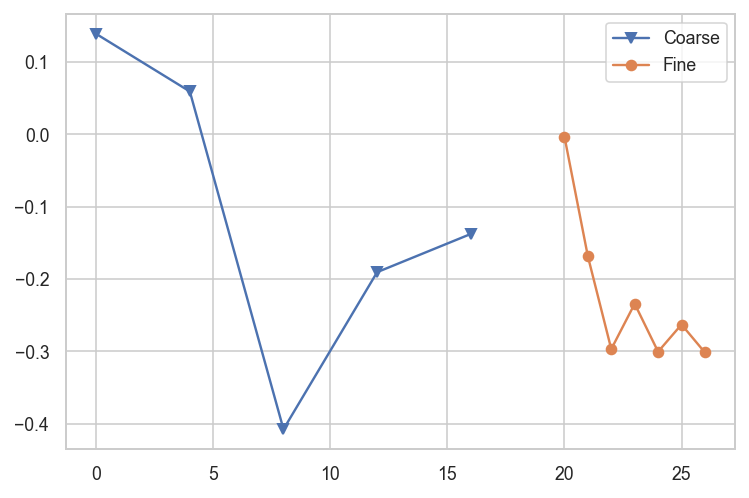

In [73]:
plt.plot(np.arange(0,4*n_coarse,4), ts2,'-v',label='Coarse')
plt.plot(np.arange(4*n_coarse,4*n_coarse+n_fine+1), ts,'-o',label='Fine')
plt.legend()
plt.grid(True)


## Code

Since code in this repository is an experimental implementation for research purposes, we have no proper API. Let's make one. Here we use a Mixin design pattern to add a definition of the custom model to our implementation.

In [74]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
sts=tfp.sts


class ModelMixin:
    dtype=tf.float64
    
    def model(self):
        print('Using mixin')
        prior = tfd.MultivariateNormalDiag(loc=tf.convert_to_tensor([0.0], dtype=self.dtype) , 
                                           scale_diag=tf.convert_to_tensor([0.5], dtype=self.dtype)
                                          )
        autoregressive = sts.Autoregressive(
            order=1,
            coefficients_prior=prior,
            observed_time_series=self.train_ts,
            name='autoregressive')
        model = sts.Sum([autoregressive], observed_time_series=self.train_ts)
        return model


In [75]:
import ssm

class TimeSeriesPredictor(ModelMixin, ssm.TimeSeriesPredictor):
    pass

class AggregatedPredictor(ModelMixin, ssm.AggregatedPredictor):
    pass

## Fine-grained model
Let's begin with fitting the AR(1) model to the fine-grained part only. We use Stochastic Variational Inference with prior assigning mostly positive values for the autoregressive coefficient.



Using mixin


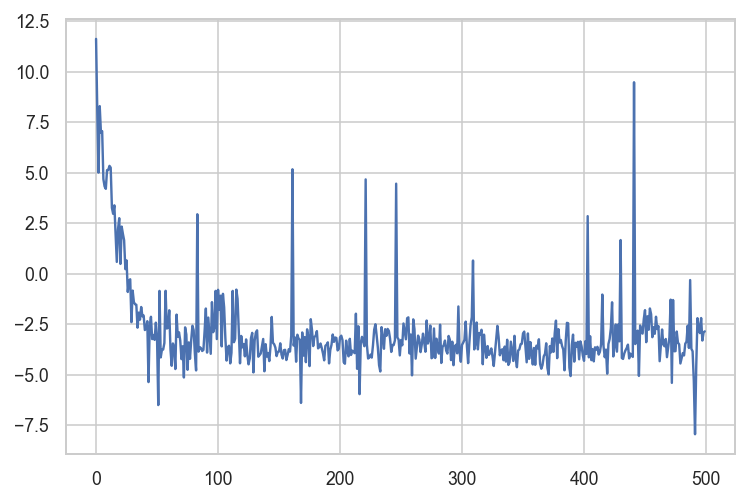

In [76]:
tf.random.set_seed(42)
predictor = TimeSeriesPredictor(num_forecast_steps=1, ts=ts)
elbo=predictor.fit(num_variational_steps=500)
plt.plot(elbo)



## Fine+ Coarse-grained model
In this step, we improve the estimation by using more observation ad aggregation level 4.

Using mixin


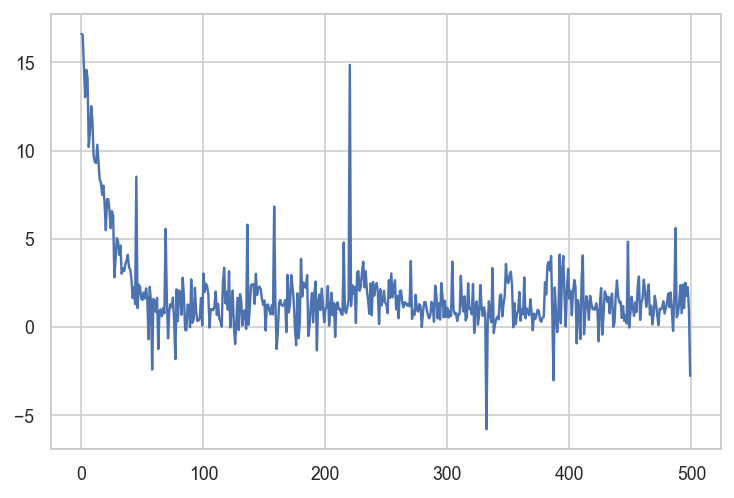

In [77]:
tf.random.set_seed(42)
ag_predictor = AggregatedPredictor(num_forecast_steps=1, ts=ts.astype(np.float32), ts2=ts2.astype(np.float32))
ag_predictor.dtype=tf.float32

elbo2=ag_predictor.fit(num_variational_steps=500)
plt.plot(elbo2)



## Results

Below we compare the posteriors obtained from two models.
Additional observations improve our estimations substantially (the true value of 0.75 is almost at the mode of the posterior. 


Using mixin


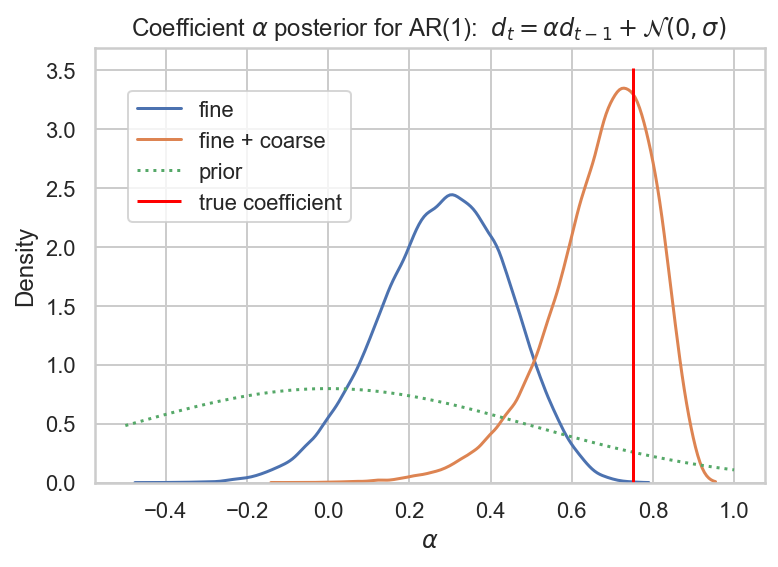

In [78]:
paper=False

if paper:
    sns.set(context='paper', style='whitegrid')
    plt.figure(figsize=(3.48,3.0))
    fname = 'posterior_c.pdf'
else:
    sns.set( style='whitegrid')
    fname = 'posterior_c.svg'

x=np.linspace(-0.5,1,200)[...,np.newaxis]

sns.kdeplot(predictor.posterior.sample(100000)['autoregressive/_coefficients'].numpy().flatten(),label="fine",cut=0)
sns.kdeplot(ag_predictor.posterior.sample(100000)[1].numpy().flatten(),label="fine + coarse",cut=0)

plt.plot(x,ag_predictor.model().components[0].parameters[0].prior.prob(x),':', label="prior")

plt.vlines(true_alpha, *plt.ylim(), color='red', label='true coefficient')
plt.xlabel(r'$\alpha$')
plt.legend(loc=(0.05,0.6))
#plt.tight_layout()
if not paper:
    plt.title(r'Coefficient $\alpha$ posterior for AR(1):  $d_t=\alpha d_{t-1}+\mathcal{N}(0,\sigma)$ ')
plt.savefig(fname)